# Sauim bicolor Vocalization Classifier and Analysis

This notebook demonstrates how to use the Perch bird vocalization classifier model from TensorFlow Hub to extract embeddings from audio files of Sauim bicolor primate and perform analysis on the extracted embeddings, such as hierarchical clustering.

The notebook covers the following steps:

1.  **Setup**: Installing necessary libraries and loading the Perch model.
2.  **Data Loading**: Downloading example audio files and a CSV file containing labels.
3.  **Feature Extraction**: Defining and using a function to extract embeddings and spectrograms from audio segments.
4.  **Spectrogram Visualization**: Plotting spectrograms to visualize the audio data.
5.  **Clustering Analysis**: Performing hierarchical clustering on the extracted embeddings and visualizing the results as a dendrogram.

In [1]:
%pip install tensorflow_hub -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.6 MB/s eta 0:00:00


In [2]:
import csv
import librosa
import gdown
import zipfile
import os
import soundfile as sf
from tqdm.notebook import trange, tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub
import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()

# Load Perch model.
model = hub.load('https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8')

### Public sound records:

*   Sauim bicolor calls:

https://drive.google.com/file/d/1WejtpTp84yjAZuqcTBFQf4dX7a6yx3vX/view?usp=drive_link

*   Background noise:

https://drive.google.com/file/d/1MyMNdiuHsNTkBT-vj3Yq_8NuV6Kqb8dt/view?usp=sharing

*   Anurans:

https://drive.google.com/file/d/1ItYCv2hWmhOS9feFGl15ar8UkHfTNN5X/view?usp=sharing

*   Birds from Xeno-Canto:

https://drive.google.com/file/d/1FS-zaPXaNtnmW8CL9Fie4I7vy1_Z93Dc/view?usp=sharing

*   Sauim parque do mindu:

https://drive.google.com/file/d/1IO5rqHbT050rpI9op4DmSqIbOOmdQiB_/view?usp=sharing

*   Records .csv file:

https://drive.google.com/file/d/1l8FgybmaLUVOHeGwdPr379DX2W5nIdaM/view?usp=sharing

*   Anthrophony:

https://drive.google.com/file/d/15LgqHDfLkcx5UYPDtlLCNw18Rml5riod/view?usp=sharing

*   Geophony:

https://drive.google.com/file/d/111nO1nDdZeiwjXBUQSMvJ3CSsB5UgPa4/view?usp=sharing

Automatically download the necessary files

In [9]:
extraction_path = '/content'

file_id = '1WejtpTp84yjAZuqcTBFQf4dX7a6yx3vX'
if not os.path.exists(os.path.join(extraction_path, 'Sauim.wav')):
    gdown.download(id=file_id, output='Sauim.wav', quiet=False)

file_id = '1MyMNdiuHsNTkBT-vj3Yq_8NuV6Kqb8dt'
if not os.path.exists(os.path.join(extraction_path, 'Background.wav')):
    gdown.download(id=file_id, output='Background.wav', quiet=False)

file_id = '1ItYCv2hWmhOS9feFGl15ar8UkHfTNN5X'
if not os.path.exists(os.path.join(extraction_path, 'Anurans.wav')):
    gdown.download(id=file_id, output='Anurans.wav', quiet=False)

file_id = '1FS-zaPXaNtnmW8CL9Fie4I7vy1_Z93Dc'
if not os.path.exists(os.path.join(extraction_path, 'Birds.wav')):
    gdown.download(id=file_id, output='Birds.wav', quiet=False)

file_id = '1IO5rqHbT050rpI9op4DmSqIbOOmdQiB_'
if not os.path.exists(os.path.join(extraction_path, 'Mindu_Saguinus bicolor_02.02.19-000.wav')):
    gdown.download(id=file_id, output='Mindu_Saguinus bicolor_02.02.19-000.wav', quiet=False)

file_id = '15LgqHDfLkcx5UYPDtlLCNw18Rml5riod'
if not os.path.exists(os.path.join(extraction_path, 'Anthrophony.wav')):
    gdown.download(id=file_id, output='Anthrophony.wav', quiet=False)

file_id = '111nO1nDdZeiwjXBUQSMvJ3CSsB5UgPa4'
if not os.path.exists(os.path.join(extraction_path, 'Geophony.wav')):
    gdown.download(id=file_id, output='Geophony.wav', quiet=False)

file_id = '1l8FgybmaLUVOHeGwdPr379DX2W5nIdaM'
if not os.path.exists(os.path.join(extraction_path, 'records.csv')):
    gdown.download(id=file_id, output='records.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=111nO1nDdZeiwjXBUQSMvJ3CSsB5UgPa4
To: /content/Geophony.wav
100%|██████████| 10.1M/10.1M [00:00<00:00, 34.0MB/s]


In [4]:
def extract_embeddings(file: str, wlen: int, hop_len: int):
    """
    Extracts embedding vectors and spectrograms from an audio file.

    Args:
        file (str): Path to the audio file.
        wlen (int): Window length in samples.
        hop_len (int): Hop length in samples.

    Returns:
        tuple: (list of embedding vectors, list of spectrogram arrays)

    Example:
        >>> sr = 32000  # Sampling rate in Hz
        >>> window_len = int(5 * sr)  # 5-second window
        >>> emb, specs = extract_embeddings('Sauim.wav', wlen=window_len, hop_len=window_len)
        >>> np.save('sauim_embedding_vectors.npy', emb)
        >>> np.save('sauim_spectrograms.npy', specs)
    """

    y, sr = librosa.load(file, sr=32000)  # Load audio
    y = y / np.max(np.abs(y)) # Normalize amplitude

    embedding_vectors = []
    spectrograms = []

    for time in tqdm(range(0, len(y), hop_len)):
        if time + wlen < len(y):
            segment = y[time:time+wlen]
            model_outputs = model.infer_tf(segment[np.newaxis, :])
            embedding_vectors.append(model_outputs['embedding'].numpy()[0])
            spectrograms.append(model_outputs['frontend'][0].T.numpy())

    return embedding_vectors, spectrograms

def plot_spectrogram(species: str, spectrograms):
    """
    Plots a Mel spectrogram in dB scale for a given species.

    Args:
        species (str): Species name.
        spectrograms (ndarray): Spectrogram array.
        sr (int): Sampling rate in Hz.

    Example:
        >>> sr = 32000
        >>> window_len = int(5 * sr)
        >>> emb, specs = extract_embeddings('Sauim.wav', wlen=window_len, hop_len=window_len)
        >>> # Plot the first extracted spectrogram
        >>> plot_spectrogram("Saguinus bicolor", specs[0], sr)
    """
    S_dB = librosa.power_to_db(spectrograms, ref=np.max) # Convert to decibels

    plt.figure(figsize=(10, 3))
    librosa.display.specshow(S_dB, sr=32000, x_axis='time', y_axis='mel',
                            hop_length=256+64, # Provide hop_length for correct time axis
                            cmap='viridis') # Ensure origin is lower for standard freq plot

    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of a 5-second segment of {species}')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency (Hz)') # Librosa will automatically format this as Mel-Hz

    plt.tight_layout()
    plt.show()

Extract embeddings and spectrograms for a 'Sauim.wav' audio file and save them as NumPy arrays.

In [5]:
sr = 32000 # Sampling rate (Hz)
window_len = int(5*sr) # 5-second window length in samples

In [ ]:
# Extract embeddings and spectrograms for each 5-second segment
sauim_embedding_vectors, sauim_spectrograms = extract_embeddings('Sauim.wav',
                                                     wlen=window_len,
                                                     hop_len=window_len)

# Save outputs to .npy files
np.save('sauim_embedding_vectors.npy', sauim_embedding_vectors)
np.save('sauim_spectrograms.npy', sauim_spectrograms)

  0%|          | 0/119 [00:00<?, ?it/s]

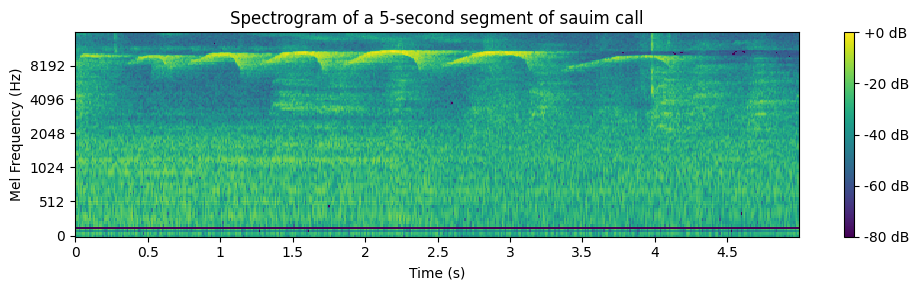

In [ ]:
plot_spectrogram('sauim call', sauim_spectrograms[0])

Background noise segments for anomaly data

In [ ]:
anomaly_embedding_vectors = []
anomaly_spectrograms = []

anomaly_embedding_vectors, anomaly_spectrograms = extract_embeddings('Background.wav',
                                                     wlen=window_len,
                                                     hop_len=window_len)

np.save('background_embedding_vectors.npy', anomaly_embedding_vectors)
np.save('background_spectrograms.npy', anomaly_spectrograms)

  0%|          | 0/180 [00:00<?, ?it/s]

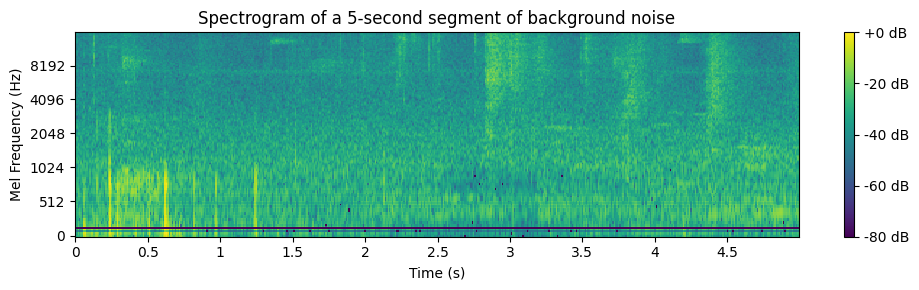

In [ ]:
plot_spectrogram('background noise', anomaly_spectrograms[0])

Anuran calls used as negative class

In [ ]:
anomaly_anurans_vectors = []
anomaly_anurans_spectrograms = []

anomaly_anurans_vectors, anomaly_anurans_spectrograms = extract_embeddings('Anurans.wav',
                                                     wlen=window_len,
                                                     hop_len=int(window_len/2))

np.save('anurans_embedding_vectors.npy', anomaly_anurans_vectors)
np.save('anurans_spectrograms.npy', anomaly_anurans_spectrograms)

  0%|          | 0/124 [00:00<?, ?it/s]

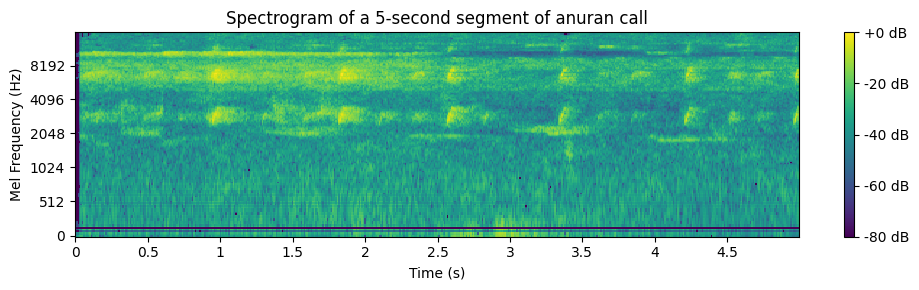

In [ ]:
plot_spectrogram('anuran call', anomaly_anurans_spectrograms[0])

Bird calls used as negative class

In [ ]:
anomaly_birds_vectors = []
anomaly_birds_spectrograms = []

anomaly_birds_vectors, anomaly_birds_spectrograms = extract_embeddings('Birds.wav',
                                                     wlen=window_len,
                                                     hop_len=window_len)

np.save('birds_embedding_vectors.npy', anomaly_birds_vectors)
np.save('birds_spectrograms.npy', anomaly_birds_spectrograms)

  0%|          | 0/131 [00:00<?, ?it/s]

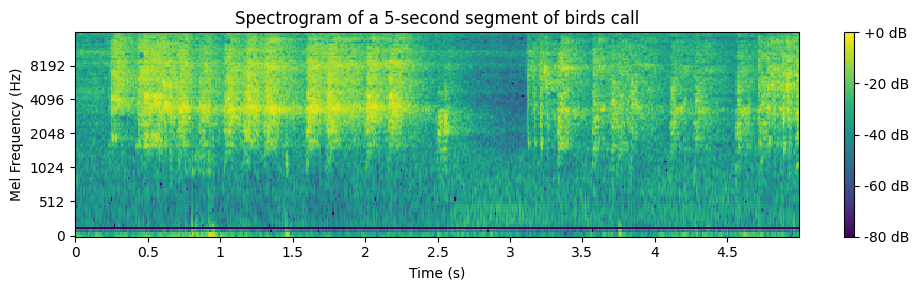

In [ ]:
plot_spectrogram('birds call', anomaly_birds_spectrograms[0])

A soundscape record used for new sauim detections

In [ ]:
soundscape_vectors = []
soundscape_spectrograms = []

step = 1
hop_len = int(step*sr) # emulates an sliding window of 5 sec length and 1 sec step

soundscape_vectors, soundscape_spectrograms = extract_embeddings('Mindu_Saguinus bicolor_02.02.19-000.wav',
                                                     wlen=window_len,
                                                     hop_len=hop_len)

np.save('soundscape_embedding_vectors.npy', soundscape_vectors)
np.save('soundscape_spectrograms.npy', soundscape_spectrograms)

  0%|          | 0/564 [00:00<?, ?it/s]

In [8]:
anthrophony_vectors = []
anthrophony_spectrograms = []

step = 2
hop_len = int(step*sr) # emulates an sliding window of 5 sec length and 1 sec step

anthrophony_vectors, anthrophony_spectrograms = extract_embeddings('Anthrophony.wav',
                                                     wlen=window_len,
                                                     hop_len=hop_len)

np.save('anthrophony_embedding_vectors.npy', anthrophony_vectors)
np.save('anthrophony_spectrograms.npy', anthrophony_spectrograms)

  0%|          | 0/86 [00:00<?, ?it/s]

In [11]:
geophony_vectors = []
geophony_spectrograms = []

step = 2
hop_len = int(step*sr) # emulates an sliding window of 5 sec length and 1 sec step

geophony_vectors, geophony_spectrograms = extract_embeddings('Geophony.wav',
                                                     wlen=window_len,
                                                     hop_len=hop_len)

np.save('geophony_embedding_vectors.npy', geophony_vectors)
np.save('geophony_spectrograms.npy', geophony_spectrograms)

  0%|          | 0/80 [00:00<?, ?it/s]

Load labels, compute cosine distance matrix from embedding vectors, perform hierarchical clustering, and plot a dendrogram.

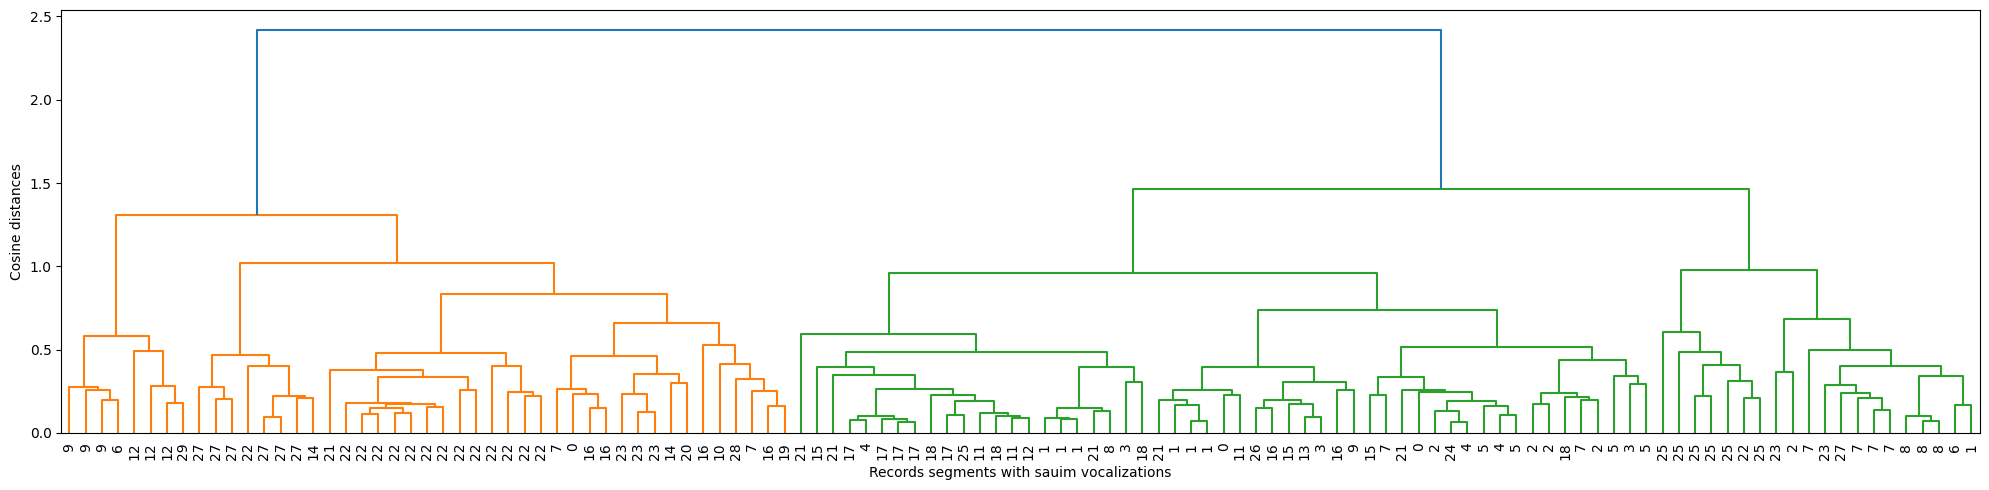

In [ ]:
# 1. Load labels from CSV
records = pd.read_csv('records.csv')  # adjust path if needed
labels = records['Bosque_S.bicolor_12.4.19-000'].tolist()

# Encode labels as integers
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# 2. Compute cosine distance matrix (condensed form)
cosine_distances = pdist(sauim_embedding_vectors, metric='cosine')

# 3. Perform hierarchical clustering
Z = linkage(cosine_distances, method='ward')  # try 'ward', 'complete', etc.

# 4. Plot dendrogram
plt.figure(figsize=(20, 5))
dendrogram(Z, labels=encoded_labels, leaf_font_size=10)
plt.xlabel("Records segments with sauim vocalizations")
plt.ylabel("Cosine distances")
plt.tight_layout()
plt.show()


In [ ]:
for i in zip(encoded_labels,labels):
    print(i)

(np.int64(23), 'Bosque_S.bicolor_12.4.19-000')
(np.int64(23), 'Bosque_S.bicolor_12.4.19-000')
(np.int64(23), 'Bosque_S.bicolor_12.4.19-000')
(np.int64(23), 'Bosque_S.bicolor_12.4.19-000')
(np.int64(23), 'Bosque_S.bicolor_12.4.19-000')
(np.int64(0), 'Bosque_S.bicolor +parauacu_11.4.19-009')
(np.int64(0), 'Bosque_S.bicolor +parauacu_11.4.19-009')
(np.int64(0), 'Bosque_S.bicolor +parauacu_11.4.19-009')
(np.int64(24), 'Bosque_S.bicolor_9.4.19-000')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_10.4.19_014')
(np.int64(22), 'Bosque_S.bicolor_1